In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import json
import pandas as pd
import seaborn as sns

from collections import OrderedDict, Counter
from operator import itemgetter

from scipy.stats.stats import pearsonr
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score, silhouette_samples

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import PercentFormatter

plt.rcParams["figure.figsize"]=15,15


marker_types = [".", "o", "v", "^", "<",
                ">", "1", "2", "3", "4",
                "8", "s", "p", "P", "h",
                "H", "+", "x", "X", "D",
                ".", "o", "v", "^", "<", '1']

np.random.shuffle(marker_types)


ESSENTIA_DIR = "/home/lorenzo/Data/longterm_data/features/"
EMB_DIR = "../data/embeddings/{}"
TRACKS = "../data/input/random_tracklist_20220104.csv"
TRACKS_FEAT = "../data/input/tracklist_features_20220104.csv"

In [2]:
from analyze_tracks import *

In [3]:
df_tracks = pd.read_csv(TRACKS, delimiter='\t')

In [4]:
DictFeat = import_features(ESSENTIA_DIR, df_tracks)

Tracks feature found: 1444


In [5]:
embeddings, filenames = import_embeddings(EMB_DIR, 'effnet_tsne', 2)
print("Embeddings found: {}".format(len(embeddings)))

Embeddings found: 1444


In [6]:
embeddings = np.vstack(embeddings)
emb_x = list(map(itemgetter(0), embeddings))
emb_y = list(map(itemgetter(1), embeddings))
DistMatrix = cdist(embeddings, embeddings, 'cosine')

## Silhouette average score: -0.29073199844570763


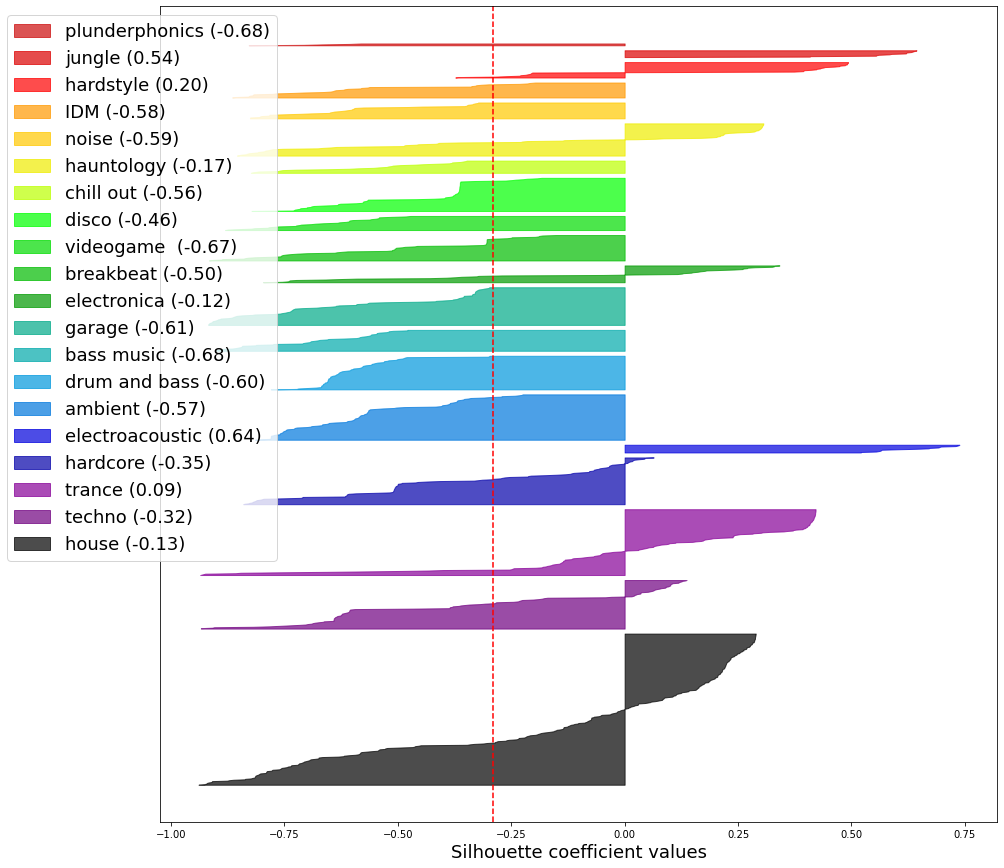

In [7]:
silhouette_analysis(DistMatrix, df_tracks, filenames)

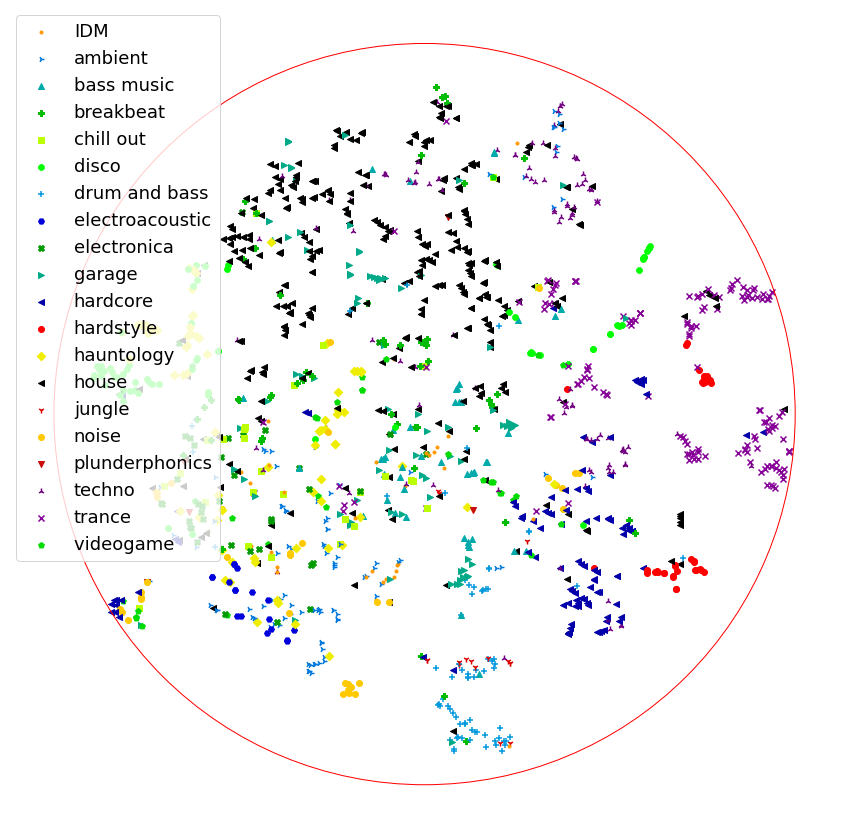

In [8]:
plot_embeddings(DistMatrix, df_tracks, emb_x, emb_y, embeddings, filenames)

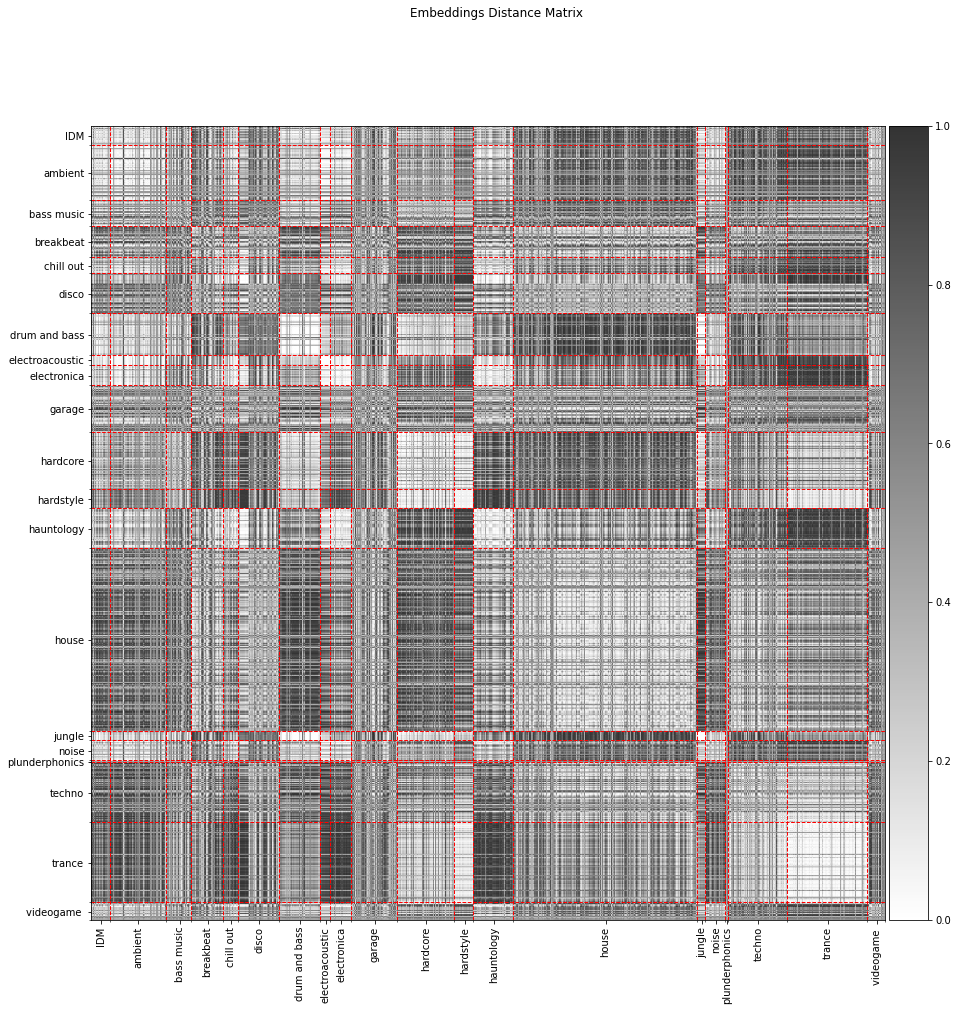

In [9]:
plot_distance_matrix(DistMatrix, df_tracks, filenames)

In [10]:
feature_correlation(DictFeat, emb_x, emb_y, filenames)


### Computing feature correlation (Spotify / Essentia)...
Feature bpm --> rho:0.295, p:2.149103096394059e-30
Feature dance --> rho:0.351, p:4.756253819822733e-43
Feature instr --> rho:0.416, p:1.368528215389459e-61
Feature acoust --> rho:0.611, p:1.889373055135196e-148

### Computing spotify feature-feature correlation...
# Pearson correlation
|        |         bpm |       dance |       instr |    acoust |
|--------|-------------|-------------|-------------|-----------|
| bpm    |  1          |  0.00757001 |  0.00962322 | -0.284783 |
| dance  |  0.00757001 |  1          | -0.152597   | -0.35451  |
| instr  |  0.00962322 | -0.152597   |  1          |  0.168109 |
| acoust | -0.284783   | -0.35451    |  0.168109   |  1        |
# P-values
|        |         bpm |       dance |       instr |      acoust |
|--------|-------------|-------------|-------------|-------------|
| bpm    | 0           | 0.773794    | 0.714832    | 2.40191e-28 |
| dance  | 0.773794    | 0           | 5.6153e-09  

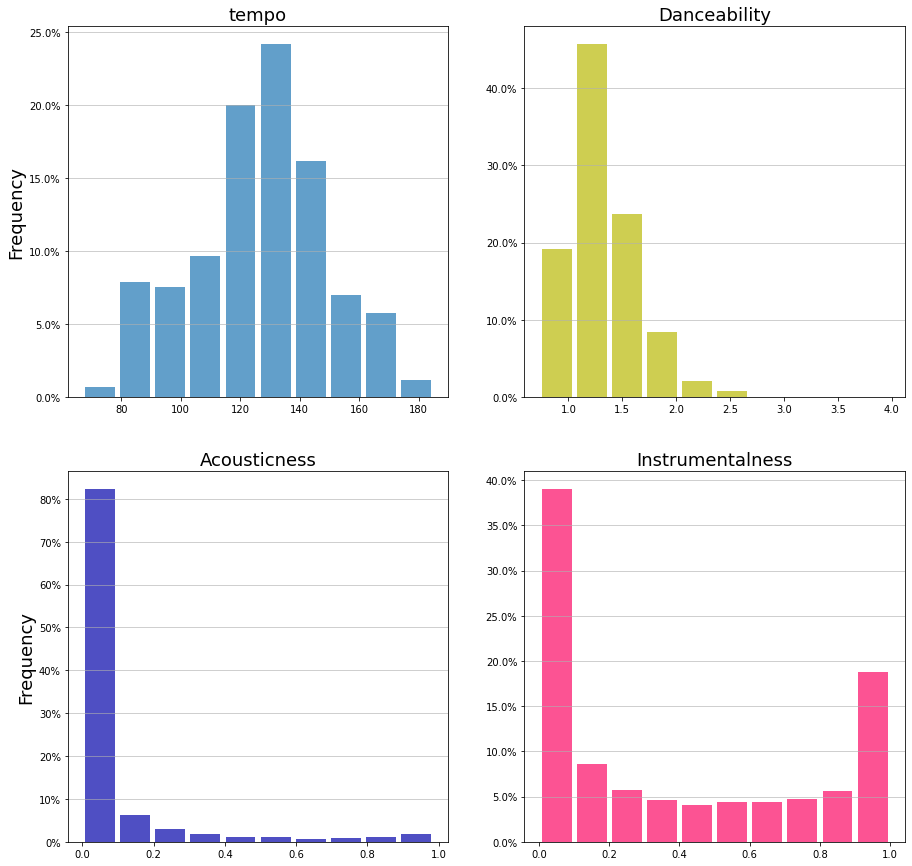

In [10]:
plot_essentia_features(DictFeat, filenames)

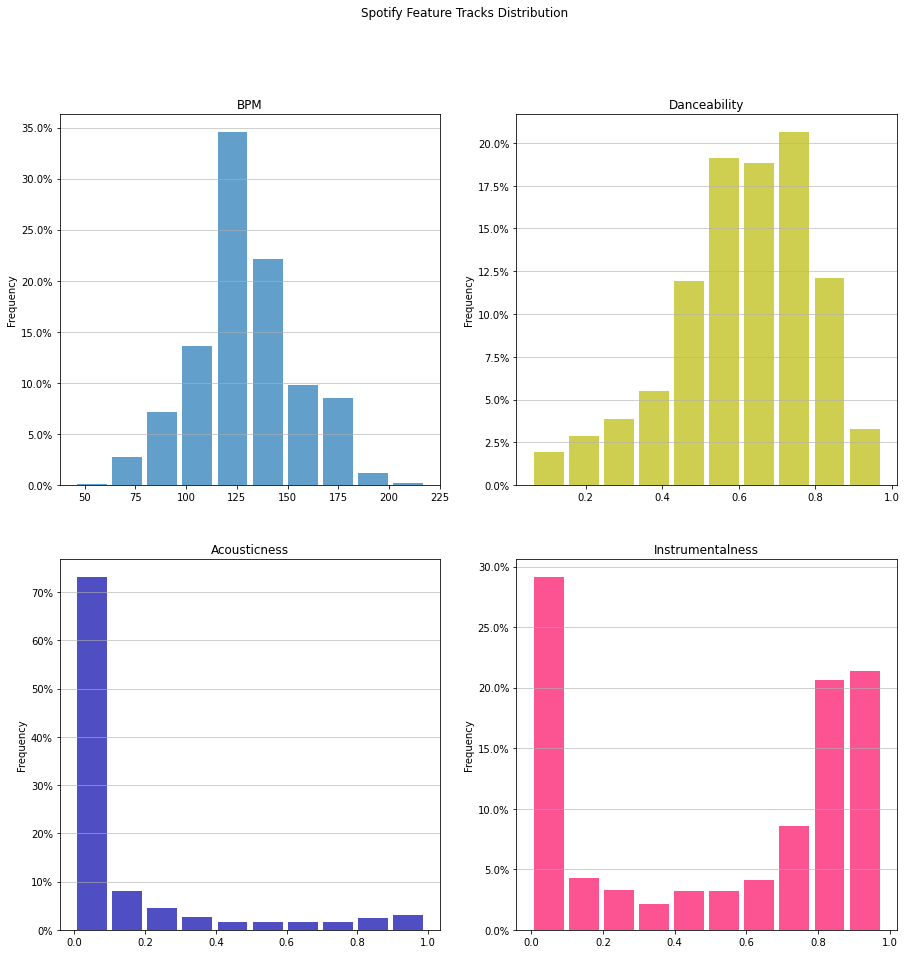

In [9]:
plot_spotify_features(DictFeat, filenames)

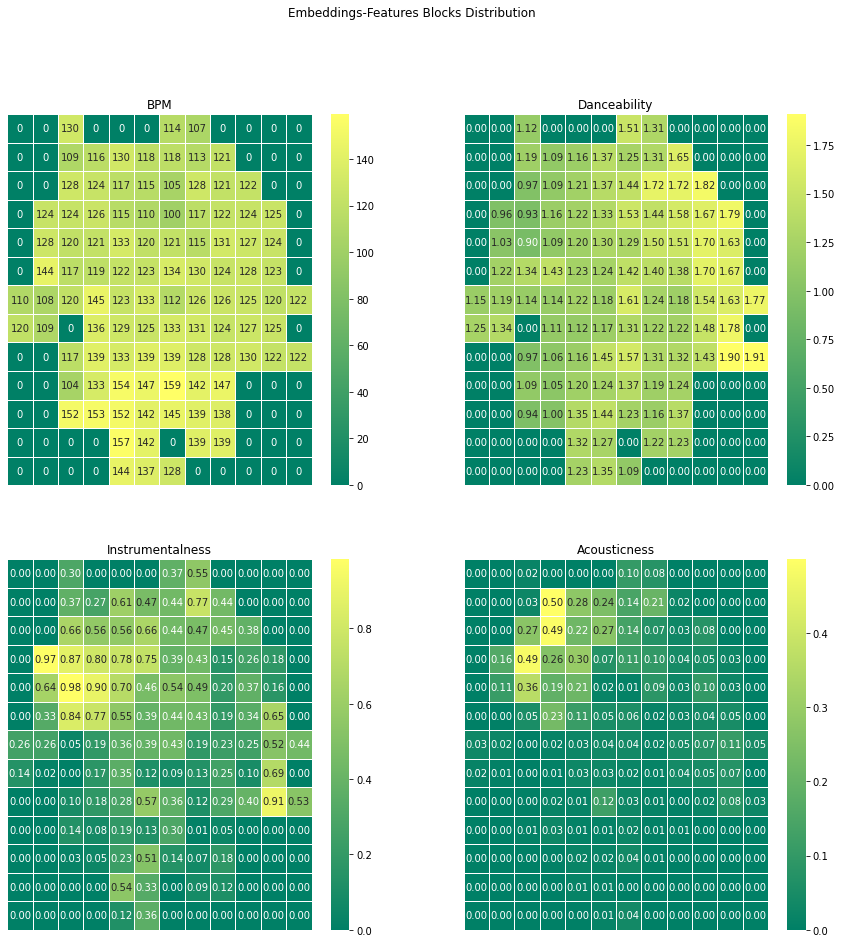

In [11]:
plot_blocks_matrix_feat(emb_x, emb_y, DictFeat, filenames)

1444

In [21]:
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.

    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all([v >= 0 for v in vertices]):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)


In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi

vor = Voronoi(embeddings)
regions, vertices = voronoi_finite_polygons_2d(vor)

(-52.380818939208986, 48.64726028442383)

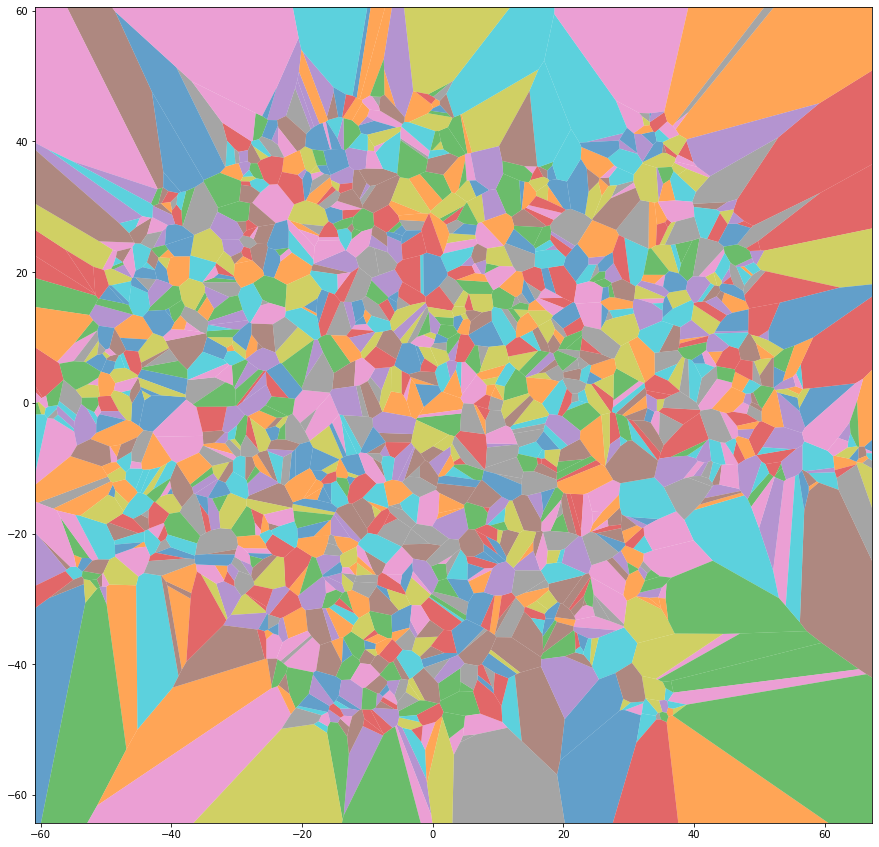

In [32]:
# colorize
for region in regions:
    polygon = vertices[region]
    plt.fill(*zip(*polygon), alpha=0.7)

#plt.plot(embeddings[:,0], embeddings[:,1], 'ko')
plt.axis('equal')
plt.xlim(vor.min_bound[0] - 0.1, vor.max_bound[0] + 0.1)
plt.ylim(vor.min_bound[1] - 0.1, vor.max_bound[1] + 0.1)